In [1]:
import pandas as pd
from nltk.corpus import stopwords
import string
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import BertTokenizer
from transformers import BertModel

In [2]:
df_train_prompt = pd.read_csv('commonlit-evaluate-student-summaries/prompts_train.csv')
df_train_summaries = pd.read_csv('commonlit-evaluate-student-summaries/summaries_train.csv')
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')

In [3]:
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [4]:
preprocessed_df = feature_engineer(df_train)

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, questions, summaries, grades):
        self.texts = texts
        self.questions = questions
        self.summaries = summaries
        self.grades = grades
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        question = self.questions[idx]
        summary = self.summaries[idx]
        grade = self.grades[idx]

        # We concatenate the text, question and summary and separate them with the [SEP] token
        inputs = self.tokenizer.encode_plus(
            text + ' [SEP] ' + question + ' [SEP] ' + summary,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return input_ids, attention_mask, grade

In [34]:
texts = preprocessed_df['prompt_text']
questions = preprocessed_df['prompt_question']
summaries = preprocessed_df['text']
grades1 = preprocessed_df['content']
grades2 = preprocessed_df['wording']

# Create datasets
dataset1 = TextDataset(texts, questions, summaries, grades1)
dataset2 = TextDataset(texts, questions, summaries, grades2)

# Create dataloaders
train_dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=True)
train_dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

In [35]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
base_model = AutoModel.from_pretrained('prajjwal1/bert-tiny')

class GradePredictor(nn.Module):
    def __init__(self):
        super(GradePredictor, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(base_model.config.hidden_size, 1)  # Predicting one grade

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        out = self.dropout(outputs.last_hidden_state[:, 0, :])
        return self.linear(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate two separate models
model1 = GradePredictor().to(device)
model2 = GradePredictor().to(device)

# Define loss function - since we're predicting a single grade in each model, we can use Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Define optimizers
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def trainer(model, num_epochs, train_dataloader, optimizer):
    
    criterion = nn.MSELoss()  # or whatever loss function is appropriate for your task
    model = model.to(device)
    
    # Initialize a dictionary to hold metrics
    metrics = {'train_loss': [], 'mse': [], 'rmse': [], 'mae': [], 'r2': [], 'lr': []}

    for epoch in range(num_epochs):
        # Training loop for model
        total_loss = 0  # Keep track of the total loss
        all_labels = []
        all_predictions = []

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            # Zero the gradients
            optimizer.zero_grad()

            # Get input data and labels
            input_ids, attention_mask, labels = batch
            labels = labels.float().to(device)

            # Forward pass
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device)).squeeze()
            outputs = outputs.unsqueeze(0) if outputs.dim() == 0 else outputs

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
            # Move labels and outputs to CPU
            labels = labels.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()

            # Store labels and predictions
            all_labels.append(labels)
            all_predictions.append(outputs)

        # Concatenate all labels and predictions
        all_labels = np.concatenate(all_labels, axis=0)
        all_predictions = np.concatenate(all_predictions, axis=0)

        # Calculate metrics
        mse = mean_squared_error(all_labels, all_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_labels, all_predictions)
        r2 = r2_score(all_labels, all_predictions)
        lr = optimizer.param_groups[0]['lr']

        # Save metrics
        metrics['train_loss'].append(total_loss / len(train_dataloader))
        metrics['mse'].append(mse)
        metrics['rmse'].append(rmse)
        metrics['mae'].append(mae)
        metrics['r2'].append(r2)
        metrics['lr'].append(lr)

    return metrics

In [41]:
trainer(model1, 10, train_dataloader1, optimizer1)

Epoch 1: 100%|██████████| 224/224 [01:33<00:00,  2.40it/s]


Epoch: 1, Total Loss:258.77339351177216, Loss:1.16, MSE: 1.16, RMSE: 1.07, MAE: 0.85, R2: -0.06, LR: 0.00


Epoch 2: 100%|██████████| 224/224 [01:34<00:00,  2.37it/s]


Epoch: 2, Total Loss:258.5090417563915, Loss:1.15, MSE: 1.15, RMSE: 1.07, MAE: 0.85, R2: -0.06, LR: 0.00


Epoch 3: 100%|██████████| 224/224 [01:35<00:00,  2.35it/s]


Epoch: 3, Total Loss:253.74255380034447, Loss:1.13, MSE: 1.13, RMSE: 1.06, MAE: 0.84, R2: -0.04, LR: 0.00


Epoch 4: 100%|██████████| 224/224 [01:34<00:00,  2.36it/s]


Epoch: 4, Total Loss:252.04837596416473, Loss:1.13, MSE: 1.13, RMSE: 1.06, MAE: 0.83, R2: -0.03, LR: 0.00


Epoch 5: 100%|██████████| 224/224 [01:35<00:00,  2.35it/s]


Epoch: 5, Total Loss:252.09599813818932, Loss:1.13, MSE: 1.13, RMSE: 1.06, MAE: 0.84, R2: -0.03, LR: 0.00


Epoch 6: 100%|██████████| 224/224 [01:35<00:00,  2.33it/s]


Epoch: 6, Total Loss:249.9986026585102, Loss:1.12, MSE: 1.12, RMSE: 1.06, MAE: 0.83, R2: -0.02, LR: 0.00


Epoch 7: 100%|██████████| 224/224 [01:36<00:00,  2.33it/s]


Epoch: 7, Total Loss:248.5925725698471, Loss:1.11, MSE: 1.11, RMSE: 1.05, MAE: 0.83, R2: -0.02, LR: 0.00


Epoch 8: 100%|██████████| 224/224 [01:34<00:00,  2.38it/s]


Epoch: 8, Total Loss:249.78878486156464, Loss:1.12, MSE: 1.12, RMSE: 1.06, MAE: 0.83, R2: -0.02, LR: 0.00


Epoch 9: 100%|██████████| 224/224 [01:34<00:00,  2.37it/s]


Epoch: 9, Total Loss:249.08163154125214, Loss:1.11, MSE: 1.11, RMSE: 1.05, MAE: 0.83, R2: -0.02, LR: 0.00


Epoch 10: 100%|██████████| 224/224 [01:35<00:00,  2.35it/s]

Epoch: 10, Total Loss:245.82104796171188, Loss:1.10, MSE: 1.10, RMSE: 1.05, MAE: 0.82, R2: -0.01, LR: 0.00


{'train_loss': [1.15523836389184,
  1.154058222126748,
  1.132779258037252,
  1.1252159641257353,
  1.1254285631169165,
  1.1160651904397778,
  1.109788270401103,
  1.1151285038462706,
  1.1119715693805898,
  1.0974153926862138],
 'mse': [1.155411,
  1.1541831,
  1.1329217,
  1.1252489,
  1.1253606,
  1.1160774,
  1.1096829,
  1.1153201,
  1.112009,
  1.0974799],
 'rmse': [1.0749005,
  1.0743291,
  1.0643879,
  1.0607775,
  1.0608301,
  1.0564456,
  1.053415,
  1.0560871,
  1.0545183,
  1.0476068],
 'mae': [0.8476144,
  0.8461545,
  0.84011036,
  0.8345508,
  0.8369054,
  0.8297773,
  0.83029306,
  0.8316072,
  0.83054125,
  0.8249168],
 'r2': [-0.061095504765936726,
  -0.0599678385696667,
  -0.04044186253710058,
  -0.033395409222010786,
  -0.033498072233478116,
  -0.02497265764670864,
  -0.019100208054818824,
  -0.024277156525449595,
  -0.021236359451172193,
  -0.00789318271990247],
 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]}

In [43]:
def predict(dataloader, model):
    # Make sure the model is in evaluation mode
    model.eval()

    all_predictions = []

    # Iterate over batches
    for batch in dataloader:
        # Get input data and labels
        input_ids, attention_mask, labels = batch

        # Move data to the same device as the model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Get the model's predictions
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Move predictions to CPU
        predictions = outputs.detach().cpu().numpy()

        # Store predictions
        all_predictions.append(predictions)

    # Concatenate all predictions
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_predictions

# Use the function to get predictions
predictions1 = predict(train_dataloader1, model1)

In [50]:
compare = pd.DataFrame(grades1)
compare['pred'] = predictions1
compare

,content,pred
0,0.205683,0.042856
1,3.272894,0.042481
2,0.205683,0.286839
3,0.567975,0.286839
4,-0.910596,0.042481
...,...,...
7160,-0.981265,0.042856
7161,-0.511077,0.042481
7162,-0.834946,0.042856
7163,-0.157460,0.286839


In [51]:
compare.describe()

,content,pred
count,7165.000000,7165.000000
mean,-0.014853,0.116956
std,1.043569,0.092002
min,-1.729859,0.042481
25%,-0.799545,0.042481
50%,-0.093814,0.042856
75%,0.499660,0.173562
max,3.900326,0.286839


<AxesSubplot:>

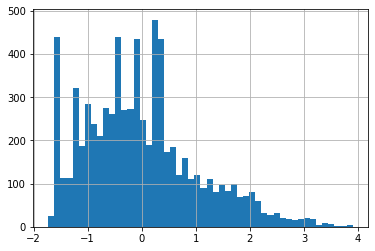

In [55]:
grades1.hist(bins=50)